# NLP for Movie Plots
*Hongyuan Jin, Eunseo Kang, Paige Harris, and Viki Papadakis*

## Purpose
We use natural language processing tools to find similar movies based on their summary plots.

## Methodology
- TF-IDF
- LDA

## WIP - improvements
Todos:
- verify the clustering efficiency

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import for Python
We import all the required Python libraries

In [224]:
import os
# print("Current Working Directory " , os.getcwd())

from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

import matplotlib as plt
import matplotlib.pyplot as pplt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

## Library import for R
We enable R in the notebook and import all the required libraries.

In [182]:
%load_ext rpy2.ipython
;

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


''

In [183]:
%%R
# install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)
library(fixest)
library(dplyr)
library(tidyr)
library(tidyverse)
# install.packages("lmtest")
library(lmtest)
library(sandwich);

## Local library import
We import all the required local libraries

In [15]:
# Include local library paths
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries

# Import local libraries

# Data import
- Movie plots (*movies_df*)
    - source:

- Other movie attributes (*movie_other*)
    - source:

- Top star list data (*topstar*)
    - source:

We first retrieve the data for the movie summary plots.

In [192]:
folder = Path("~/Dropbox/Course/PSTAT234/spr21/pstat234-final-project")
# Change the path do your own directory

movies_df = pd.read_csv(folder/'wiki_movie_plots_deduped.csv')
movies_df.head(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


## Data for Movie Plots
We retrieve the data for the movies that were:
- Produced in the US
- Released between 1990 and 2010

This returns the set of 4631 movies in total.

In [193]:
# movies_df_sub = movies_df[(movies_df['Origin/Ethnicity']=="American")].reset_index(drop=True)
movies_df_sub = movies_df[(movies_df['Release Year']>=1990) &
                          (movies_df['Release Year']<=2010) &
                          (movies_df['Origin/Ethnicity']=="American")].\
    reset_index(drop=True)
# movies_df_sub = movies_df[(movies_df['Release Year']==2005) &
                          # (movies_df['Origin/Ethnicity']=="American")].\
    # reset_index(drop=True)
movies_df_sub = movies_df_sub.drop(['Origin/Ethnicity', 'Wiki Page'], axis = 1)
movies_df_sub.head(5)
# 4631 movies to analyze

,Release Year,Title,Director,Cast,Genre,Plot
0,1990,The Adventures of Ford Fairlane,Renny Harlin,"Andrew Dice Clay, Wayne Newton, Priscilla Pres...",comedy,Ford Fairlane (Andrew Dice Clay) is seen sitti...
1,1990,"After Dark, My Sweet",James Foley,"Jason Patric, Rachel Ward, Bruce Dern",mystery,"Ex-boxer Kevin ""Kid"" Collins is a drifter and ..."
2,1990,Air America,Roger Spottiswoode,"Mel Gibson, Robert Downey, Jr., Nancy Travis",comedy,"In late 1969, Billy Covington (Robert Downey J..."
3,1990,Alice,Woody Allen,"Mia Farrow, Joe Mantegna, William Hurt, Alec B...",comedy,Alice Tate is an upper-class New York housewif...
4,1990,Almost an Angel,John Cornell,"Paul Hogan, Elias Koteas, Charlton Heston",comedy,"Terry Dean (Paul Hogan), a professional burgla..."


In [194]:
movies_df_sub['Plot'].apply(len).describe()

count     4631.000000
mean      3194.705031
std       1759.174164
min         35.000000
25%       1916.500000
50%       3430.000000
75%       4205.000000
max      25123.000000
Name: Plot, dtype: float64

The above says that each plot contains on average 3195 tokens.

# Data Processing for Movie Plots

## NLP
- TF-IDF
- LDA

Eventually, we want to cluster the movies with similar plots based on the NLP analysis.

### TF-IDF

In [339]:
stemmer = SnowballStemmer("english", ignore_stopwords=False)

def normalize(X):
    normalized = []
    totalvocab_tokenized = []
    for x in X:
        words = nltk.word_tokenize(x)
        normalized.append(' '.join([stemmer.stem(word) for word in words if re.match('[a-zA-Z]+', word)]))
        totalvocab_tokenized.extend(words)
    return normalized

pipe = Pipeline([
    ('normalize', FunctionTransformer(normalize, validate=False)),
    ('counter_vectorizer', CountVectorizer(
        max_df=0.8, max_features=200000,
        min_df=0.2, stop_words='english',
        ngram_range=(1, 3)
    )),
    ('tfidf_transform', TfidfTransformer())
])

In [196]:
# Applying to the movie plots

tfidf_matrix = pipe.fit_transform([x for x in movies_df_sub['Plot']])
print(tfidf_matrix.shape)
# print(tfidf_matrix)

(4631, 118)


In [197]:
# Evaluate the similarity among the movies from the plot word frequency
similarity_distance = 1 - cosine_similarity(tfidf_matrix)
# similarity_distance

We test for finding similar movies for a given title

In [198]:
# this returns the top 10 most similar movies for a given movie title
# based on the cosine similarity

def find_similar(title):
    index = movies_df_sub[movies_df_sub['Title'] == title].index[0]
    vector = similarity_distance[index, :]
    most_similar = movies_df_sub.iloc[np.argsort(vector)[0:10], 0:2]
    return most_similar

### Example
The movies similar to *Madagascar (2005)* according to TF-IDF.

In [199]:
print(find_similar('Madagascar'))

      Release Year                           Title
3374          2005                      Madagascar
1194          1995      The Pebble and the Penguin
3607          2006                      Happy Feet
1775          1997                 Robinson Crusoe
2602          2001                Saving Silverman
3094          2004     Clifford's Really Big Movie
4497          2010                          Frozen
1269          1996  Alien Nation: The Enemy Within
1955          1998                      The Mighty
1306          1996           Cannibal! The Musical


### Movie clustering based on TF-IDF

- Kmeans clustering
- 23 clusters, in comparison to the number of Genres
- create an attribute *cluster_tfidf_first* for the cluster labeling in the dataframe

In [227]:
from sklearn.cluster import KMeans

# num_clusters = len(np.unique(movies_df_sub['Genre']))
num_clusters = 23
# print(num_clusters)
km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

import joblib

joblib.dump(km, 'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
cluster_tfidf_first = km.labels_.tolist()

In [ ]:
templist = {'title': movies_df_sub["Title"], 'Release_year':  movies_df_sub["Release Year"],
            'Plot':  movies_df_sub['Plot'], 'cluster_tfidf_first': cluster_tfidf_first,
            'Director':  movies_df_sub['Director'], 'Genre':  movies_df_sub['Genre']}
frame = pd.DataFrame(data=templist)
# frame.head(2)
# print(frame['cluster_tfidf_first'].value_counts())

### Visualize the Clusters

/Users/aj/PycharmProjects/film_python/jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



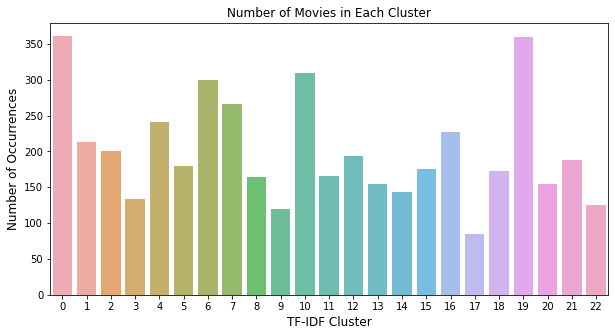

In [229]:
clus_count = frame['cluster_tfidf_first'].value_counts()
pplt.figure(figsize=(10,5))
sns.barplot(clus_count.index, clus_count.values, alpha=0.8)
pplt.title('Number of Movies in Each Cluster')
pplt.ylabel('Number of Occurrences', fontsize=12)
pplt.xlabel('TF-IDF Cluster', fontsize=12)
pplt.show()

We show the first four movies in each cluster for first four clusters.

In [234]:
frame_select = frame[['title', 'cluster_tfidf_first', 'Genre', 'Release_year']]
frame_select.sort_values(['cluster_tfidf_first']).groupby('cluster_tfidf_first').head(4)[:16]

,title,cluster_tfidf_first,Genre,Release_year
766,We're Back! A Dinosaur's Story,0,animated,1993
2048,The Wedding Singer,0,comedy,1998
821,Clerks,0,comedy,1994
2994,The Order,0,"action, thriller",2003
3440,Underclassman,1,comedy,2005
608,Aspen Extreme,1,drama,1993
1365,Foxfire,1,unknown,1996
1129,The Incredibly True Adventure of Two Girls in ...,1,unknown,1995
2850,xXx,2,action,2002
4197,Star Wars: The Clone Wars,2,animation,2008


We show the top words in each cluster below.


In [298]:
temp = frame.groupby('cluster_tfidf_first').sample(4)

cv=CountVectorizer(max_df=0.85,stop_words=stop_words,max_features=10000)

# keywords_cluster = []
# for i in frame.cluster_tfidf_first.to_list():
#     word_count_vector[i]=cv.fit_transform([x for x in temp['Plot']])
#     keywords_cluster.append(list(cv.vocabulary_.keys())[:10])


[TBU] Word cloud for each cluster

In [300]:
# wordcloud_cluster = []
# for i in frame.cluster_tfidf_first.to_list()[:2]:
#     wordcloud_cluster[i] = WordCloud().generate_from_frequencies(temp['Plot'])
#     pplt.imshow(wordcloud_cluster[i])

## LDA

In [304]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

processed_docs = frame['Plot'].map(preprocess)
processed_docs[:10]

dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    # print(k, v)
    count += 1
    if count > 15:
        break

dictionary.filter_extremes(no_below=20, no_above=0.1, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=23, id2word=dictionary, passes=2, workers=3)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))


Topic: 0 Word: 0.004*"luci" + 0.003*"georg" + 0.003*"jam" + 0.003*"juli" + 0.002*"mickey" + 0.002*"jacki" + 0.002*"mike" + 0.002*"robert" + 0.002*"nina" + 0.002*"pete"
Topic: 1 Word: 0.003*"wendi" + 0.003*"jack" + 0.003*"charli" + 0.002*"mari" + 0.002*"paul" + 0.002*"joey" + 0.002*"eddi" + 0.002*"billi" + 0.002*"michael" + 0.002*"connor"
Topic: 2 Word: 0.002*"jess" + 0.002*"barri" + 0.002*"sydney" + 0.002*"wade" + 0.002*"helen" + 0.002*"david" + 0.002*"harri" + 0.002*"billi" + 0.002*"base" + 0.002*"killer"
Topic: 3 Word: 0.004*"mitch" + 0.003*"abbi" + 0.003*"freddi" + 0.002*"danni" + 0.002*"ship" + 0.002*"calvin" + 0.002*"king" + 0.002*"april" + 0.002*"alexand" + 0.002*"mari"
Topic: 4 Word: 0.006*"harri" + 0.003*"jack" + 0.003*"scott" + 0.003*"cindi" + 0.003*"anna" + 0.003*"franki" + 0.002*"jake" + 0.002*"lenni" + 0.002*"castl" + 0.002*"kate"
Topic: 5 Word: 0.005*"michael" + 0.002*"smith" + 0.002*"paul" + 0.002*"georg" + 0.002*"isabel" + 0.002*"vincent" + 0.002*"tommi" + 0.002*"bishop"

The above shows the distribution of topics by the tokens.
- the algorithm seems to pick up the distinction across the movie plots by the character names
- we cluser the movies based on this LDA result and further visualize the movies within the same cluster
- come up with an amendment for the issue in the next section

### Cluster based on LDA

- Based on the major topic (by the highest probability)
- fuzzy Kmeans (TBA)

In [388]:
lda_corpus = lda_model_tfidf[corpus_tfidf]
all_topics = lda_model_tfidf.get_document_topics(corpus_tfidf)

num_docs = len(all_topics)

all_topics_csr= gensim.matutils.corpus2csc(all_topics)
all_topics_numpy= all_topics_csr.T.toarray()

major_topic = [np.argmax(arr) for arr in all_topics_numpy]
frame['cluster_lda_major_first']= major_topic

/Users/aj/PycharmProjects/film_python/jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



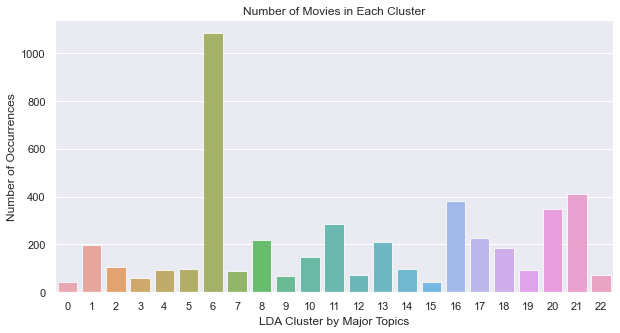

In [389]:
clus_count = frame['cluster_lda_major_first'].value_counts()
pplt.figure(figsize=(10,5))
sns.barplot(clus_count.index, clus_count.values, alpha=0.8)
pplt.title('Number of Movies in Each Cluster')
pplt.ylabel('Number of Occurrences', fontsize=12)
pplt.xlabel('LDA Cluster by Major Topics', fontsize=12)
pplt.show()

In [498]:
# print(frame[frame['cluster_lda_major_first'==6]].title[:10])

In [325]:
# Copyright Mathieu Blondel December 2011
# License: BSD 3 clause
# https://gist.github.com/mblondel/1451300
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans as KMeansGood
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from sklearn.datasets import make_blobs

##############################################################################
class KMeans(BaseEstimator):

    def __init__(self, k, max_iter=100, random_state=0, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _e_step(self, X):
        self.labels_ = euclidean_distances(X, self.cluster_centers_,
                                           squared=True).argmin(axis=1)

    def _average(self, X):
        return X.mean(axis=0)

    def _m_step(self, X):
        X_center = None
        for center_id in range(self.k):
            center_mask = self.labels_ == center_id
            if not np.any(center_mask):
                # The centroid of empty clusters is set to the center of
                # everything
                if X_center is None:
                    X_center = self._average(X)
                self.cluster_centers_[center_id] = X_center
            else:
                self.cluster_centers_[center_id] = self._average(X[center_mask])

    def fit(self, X, y=None):
        n_samples = X.shape[0]
        vdata = np.mean(np.var(X, 0))

        random_state = check_random_state(self.random_state)
        self.labels_ = random_state.permutation(n_samples)[:self.k]
        self.cluster_centers_ = X[self.labels_]

        for i in range(self.max_iter):
            centers_old = self.cluster_centers_.copy()

            self._e_step(X)
            self._m_step(X)

            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata:
                break

        return self

class KMedians(KMeans):

    def _e_step(self, X):
        self.labels_ = manhattan_distances(X, self.cluster_centers_).argmin(axis=1)

    def _average(self, X):
        return np.median(X, axis=0)

class FuzzyKMeans(KMeans):

    def __init__(self, k, m=2, max_iter=100, random_state=0, tol=1e-4):
        """
        m > 1: fuzzy-ness parameter
        The closer to m is to 1, the closter to hard kmeans.
        The bigger m, the fuzzier (converge to the global cluster).
        """
        self.k = k
        assert m > 1
        self.m = m
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _e_step(self, X):
        D = 1.0 / euclidean_distances(X, self.cluster_centers_, squared=True)
        D **= 1.0 / (self.m - 1)
        D /= np.sum(D, axis=1)[:, np.newaxis]
        # shape: n_samples x k
        self.fuzzy_labels_ = D
        self.labels_ = self.fuzzy_labels_.argmax(axis=1)

    def _m_step(self, X):
        weights = self.fuzzy_labels_ ** self.m
        # shape: n_clusters x n_features
        self.cluster_centers_ = np.dot(X.T, weights).T
        self.cluster_centers_ /= weights.sum(axis=0)[:, np.newaxis]

    def fit(self, X, y=None):
        n_samples, n_features = X.shape
        vdata = np.mean(np.var(X, 0))

        random_state = check_random_state(self.random_state)
        self.fuzzy_labels_ = random_state.rand(n_samples, self.k)
        self.fuzzy_labels_ /= self.fuzzy_labels_.sum(axis=1)[:, np.newaxis]
        self._m_step(X)

        for i in range(self.max_iter):
            centers_old = self.cluster_centers_.copy()

            self._e_step(X)
            self._m_step(X)

            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata:
                break

        return self

In [497]:
# we applied the above fuzzyKmeans clustering to our LDA outcomes
# fuzzy_kmeans = FuzzyKMeans(k = 23, m = 1.5)
# the closer m is to 1, the closer the clustering is to hard clustering

# fuzzy_kmeans.fit(all_topics)

## Import data for names and replace the character names with string 'character'

We find that the topic modeling is affected by the character names.
Below we will replace the names with the string 'Character'

*Data source: Social Security https://www.ssa.gov/oact/babynames/limits.html*

In [326]:
# load names.zip which has more names data txt files
import zipfile
with zipfile.ZipFile('/Users/aj/Dropbox/Course/PSTAT234/spr21/pstat234-final-project/names.zip', 'r') as zip_ref:
    zip_ref.extractall('names/')

In [327]:
allnames_files = Path('names').glob('yob*')
# print(allnames_files)
# allnames_files.sort()
allnames_list = list()

for f in allnames_files:
    step_1 = pd.read_csv(f, delimiter = ',', header=None)
    allnames_list.append(step_1)
allnames = pd.concat(allnames_list)
allnames.columns = ["name", 'gender', 'count']
allnames.shape
# drop gender and aggregate the counts groupby names
allnames.drop(['gender'], axis = 1, inplace = True)

In [328]:
# allnames.dtypes
allnames['totalcount'] = allnames['count'].\
    groupby(allnames['name']).transform('sum')
allnames.drop('count', axis = 1, inplace=True)
allnames.head
allnames.describe()

,totalcount
count,2.020863e+06
mean,3.401396e+04
std,1.910011e+05
min,5.000000e+00
25%,2.540000e+02
50%,9.560000e+02
75%,5.048000e+03
max,5.213689e+06


In [329]:
# drop duplicates and keep only the names with count larger than 100
allnames.drop_duplicates(subset='name', inplace= True)
allnames = allnames.sort_values(by = ['totalcount'], ascending=False)
# allnames = allnames[allnames['totalcount']>=5000]
allnames.head()
# there are in total 100364 unique names in the dataset, we will use \
# top 2000 names by the totalcount

,name,totalcount
3359,James,5213689
4466,John,5163958
5114,Robert,4849738
1567,Michael,4405274
3521,William,4159868


### Replace the names in the plot with 'Character'

There are several shortfalls with this approach:
- Replacement took a long time to run
    - Looping over each movie plot with 1000 names took about 31 minutes.
- The updated plots still contain the names that were not within the top 1000 list.
- Last names were not replaced well

Reason: the time horizon is long, the words (excl. the names) that were used to
describe the plots appear to be less prominent than the character names.

Next Amendment:
   - try run the analysis on movied fall on a shorter time window of
     the release years (eg. 5 years), where the distinction in the words
     for content may be more prominent than the names.

In [79]:
# %%time
# # DO NOT NEED TO RUN
# ALERT: THIS CELL TAKES EVEN LONGER TO RUN
# The name is a list from the all names data
# there are in total 100364 unique names in the dataset, we will use \
# top 1000 names by the totalcount
# new_movie_sub = movies_df[(movies_df['Release Year']>=1990) &
#                           (movies_df['Release Year']<=2010) &
#                           (movies_df['Origin/Ethnicity']=="American")].\
#     reset_index(drop=True)
#
# new_movie_sub = new_movie_sub.drop(['Origin/Ethnicity', 'Wiki Page'], axis = 1)
# name = allnames.name.to_list()
# for i in new_movie_sub.index:
#     for tag in name[:1000]:
#         new_movie_sub.Plot[i] = re.sub(r'\b' + tag + r'\b', 'Character', new_movie_sub.Plot[i])

CPU times: user 31min 24s, sys: 15.8 s, total: 31min 40s
Wall time: 31min 29s


In [80]:
# # save the new movie plot to data
# new_movie_sub.to_csv('replaced_character_movie_plots.csv', index=False)


## Load the data for updated plots

In [337]:
new_movies_df = pd.read_csv("replaced_character_movie_plots.csv")
new_movies_df.Plot[5]
new_movies_df.shape

(4631, 6)

### TF-IDF with the updated plot summaries

In [345]:
tfidf_matrix_new = pipe.fit_transform([x for x in new_movies_df['Plot']])
print(tfidf_matrix_new.shape)

num_clusters = 23
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix_new)

joblib.dump(km, 'doc_cluster_new.pkl')

km = joblib.load('doc_cluster_new.pkl')
clusters = km.labels_.tolist()

(4631, 120)


In [346]:
# print(len(clusters))

4631


In [347]:
frame['cluster_tfidf_second'] = clusters

In [349]:
films_select = frame[['title', 'cluster_tfidf_second', 'Genre', 'Release_year']]
films_select.sort_values(['cluster_tfidf_second']).groupby('cluster_tfidf_second').head(4)[:16]

,title,cluster_tfidf_second,Genre,Release_year
616,Body of Evidence,0,thriller,1993
4426,Up in the Air,0,comedy-drama,2009
4100,Forgetting Sarah Marshall,0,comedy,2008
767,The Wedding Banquet,0,"drama, comedy",1993
2517,Ghosts of Mars,1,science fiction,2001
2541,Joe Somebody,1,comedy,2001
4443,Alice in Wonderland,1,"family, fantasy",2010
602,Airborne,1,comedy,1993
2391,Rules of Engagement,2,war,2000
1924,Homegrown,2,comedy,1998


In [357]:
similarity_distance_new = 1 - cosine_similarity(tfidf_matrix_new)
# similarity_distance_new

def find_similar(title):
    index = frame[frame['title'] == title].index[0]
    vector = similarity_distance_new[index, :]
    most_similar = frame.iloc[np.argsort(vector)[0:10], 0:2]
    return most_similar

print(find_similar('Madagascar'))


                              title  Release_year
3374                     Madagascar          2005
1194     The Pebble and the Penguin          1995
3607                     Happy Feet          2006
1775                Robinson Crusoe          1997
4497                         Frozen          2010
1955                     The Mighty          1998
625           Cannibal! The Musical          1993
1306          Cannibal! The Musical          1996
2835                Treasure Planet          2002
4229  You Don't Mess with the Zohan          2008


Word Cloud for the corpus

In [378]:
from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in new_movies_df.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

Word Cloud with all movie plots

In [379]:
# unique_string=(" ").join(plots)
# wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
# plt.pyplot.imshow(wordcloud, interpolation='bilinear')
# plt.pyplot.axis("off")
# plt.pyplot.show()

Word cloud with all movie plots for the most important words using countervectorizer

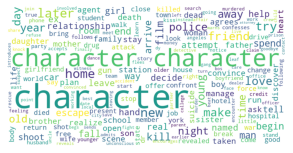

In [380]:
# the most important words in messages using countvectorizer
cv = CountVectorizer(analyzer = "word",stop_words = 'english', max_features = 1000, ngram_range=(2,2))
important_words = cv.fit_transform(plots)
fig_words = cv.vocabulary_

#wordcloud for important words
unique_data=(" ").join(fig_words)
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate(unique_data)
plt.pyplot.imshow(wordcloud)
plt.pyplot.axis("off")
plt.pyplot.show()
plt.pyplot.close()

LDA with the updated plot summaries

In [395]:
processed_docs = new_movies_df['Plot'].map(preprocess)
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    # print(k, v)
    count += 1
    if count > 15:
        break

dictionary.filter_extremes(no_below=20, no_above=0.1, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=23, id2word=dictionary, passes=2, workers=3)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))


Topic: 0 Word: 0.002*"island" + 0.002*"crew" + 0.002*"stan" + 0.002*"wed" + 0.002*"ship" + 0.002*"camp" + 0.001*"marin" + 0.001*"club" + 0.001*"hotel" + 0.001*"machin"
Topic: 1 Word: 0.005*"nick" + 0.004*"vampir" + 0.002*"infect" + 0.002*"anim" + 0.002*"affair" + 0.002*"boss" + 0.002*"white" + 0.001*"shooter" + 0.001*"babi" + 0.001*"buck"
Topic: 2 Word: 0.003*"satan" + 0.002*"presid" + 0.002*"matt" + 0.002*"christma" + 0.002*"evil" + 0.002*"coach" + 0.002*"band" + 0.002*"gang" + 0.002*"vote" + 0.002*"ghost"
Topic: 3 Word: 0.003*"vinc" + 0.003*"nicki" + 0.002*"restaur" + 0.002*"hors" + 0.002*"kidnap" + 0.002*"boy" + 0.001*"sullivan" + 0.001*"danc" + 0.001*"marriag" + 0.001*"reveng"
Topic: 4 Word: 0.003*"doug" + 0.002*"book" + 0.002*"ship" + 0.002*"player" + 0.002*"elliot" + 0.001*"debt" + 0.001*"boy" + 0.001*"addict" + 0.001*"killer" + 0.001*"tournament"
Topic: 5 Word: 0.003*"pete" + 0.002*"colleg" + 0.002*"hotel" + 0.002*"store" + 0.002*"wed" + 0.002*"kid" + 0.002*"gang" + 0.002*"wish"

In [400]:
lda_corpus = lda_model_tfidf[corpus_tfidf]
all_topics = lda_model_tfidf.get_document_topics(corpus_tfidf)

num_docs = len(all_topics)

all_topics_csr= gensim.matutils.corpus2csc(all_topics)
all_topics_numpy= all_topics_csr.T.toarray()

major_topic = [np.argmax(arr) for arr in all_topics_numpy]
frame['cluster_lda_major_second']= major_topic

/Users/aj/PycharmProjects/film_python/jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



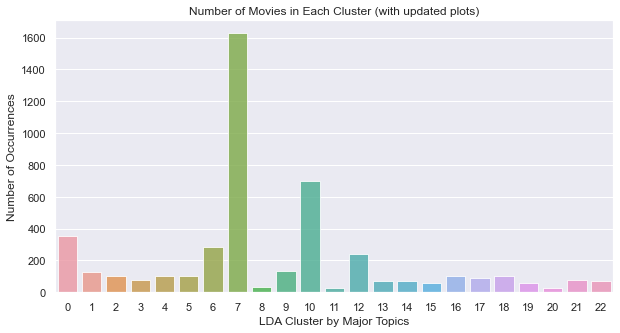

In [401]:
clus_count = frame['cluster_lda_major_second'].value_counts()
pplt.figure(figsize=(10, 5))
sns.barplot(clus_count.index, clus_count.values, alpha=0.8)
pplt.title('Number of Movies in Each Cluster (with updated plots)')
pplt.ylabel('Number of Occurrences', fontsize=12)
pplt.xlabel('LDA Cluster by Major Topics', fontsize=12)
pplt.show()

In [403]:
frame.columns
frame_new = frame[['title', 'Release_year', 'cluster_tfidf_first',
'cluster_tfidf_second', 'cluster_lda_major_first', 'cluster_lda_major_second']]

In [404]:
# save all the above result on movie plots to a data file
frame_new.to_csv(os.path.join(folder, r'plot_clusters.csv'), index=False)

## Import the data with other movie attributes

In [407]:
movies_other = pd.read_csv(folder/'df_pstat234.csv')
movies_other.describe()

,us.year,us.quarter,domestic_bo,budget_nielsen,budget_numbers,international_bo
count,13016.000000,5052.000000,5.718000e+03,6.058000e+03,2.006000e+03,1.972000e+03
mean,2000.249923,2.625099,2.540196e+07,2.160889e+07,4.056754e+07,6.165253e+07
std,5.967295,1.102717,4.608372e+07,3.089150e+07,3.969142e+07,1.155018e+08
min,1990.000000,1.000000,9.500000e+01,2.200000e+02,7.000000e+03,3.900000e+01
25%,1995.000000,2.000000,1.866802e+05,2.000000e+06,1.300000e+07,2.782723e+06
50%,2000.000000,3.000000,5.991562e+06,1.000000e+07,2.900000e+07,2.385216e+07
75%,2006.000000,4.000000,3.117350e+07,2.754125e+07,5.737500e+07,7.321041e+07
max,2010.000000,4.000000,4.364710e+08,3.000000e+08,2.600000e+08,2.028194e+09


In [409]:
movies_other[["domestic_bo", "budget_nielsen", "international_bo", "budget_numbers"]].describe()


,domestic_bo,budget_nielsen,international_bo,budget_numbers
count,5.718000e+03,6.058000e+03,1.972000e+03,2.006000e+03
mean,2.540196e+07,2.160889e+07,6.165253e+07,4.056754e+07
std,4.608372e+07,3.089150e+07,1.155018e+08,3.969142e+07
min,9.500000e+01,2.200000e+02,3.900000e+01,7.000000e+03
25%,1.866802e+05,2.000000e+06,2.782723e+06,1.300000e+07
50%,5.991562e+06,1.000000e+07,2.385216e+07,2.900000e+07
75%,3.117350e+07,2.754125e+07,7.321041e+07,5.737500e+07
max,4.364710e+08,3.000000e+08,2.028194e+09,2.600000e+08


### Visualize the plot text (word cloud)

- Overall topic
- US-born director
- Foreign-born director
- Genre


## Import the data with big star names
*Source: https://www.imdb.com/list/ls058011111/?sort=list_order,asc&mode=detail*
*Scraped, code attached separately*

In [410]:
topstar = pd.read_csv(folder/'topstar.csv')
topstar.head(5)
topstar = topstar.Name.str.lstrip(' ')

,Name
0,Robert De Niro
1,Jack Nicholson
2,Marlon Brando
3,Denzel Washington
4,Katharine Hepburn


generate top star indicator for each movie if one of the main actors is on
the list of top star from the above source.


In [ ]:
# movies_other['topstar']=0
#Do not run this cell! It takes more than two hours! I saved the result file as 'merged with topstar.csv' and we will use that for the following step.
#for j in range(0,1000):
#    for i in range(0,13016):
#        if movies_other.Actor1.tolist()[i]== topstar[j]:
#            movies_other['topstar'][i]=1
#        elif movies_other.Actor2.tolist()[i]==topstar[j]:
#            movies_other['topstar'][i]=1
#        elif movies_other.Actor3.tolist()[i]== topstar[j]:
#            movies_other['topstar'][i]=1
#        elif movies_other.Actor4.tolist()[i]== topstar[j]:
#            movies_other['topstar'][i]=1
#        elif movies_other.Actor5.tolist()[i]== topstar[j]:
#            movies_other['topstar'][i]=1
#    print(j)


In [ ]:
# movies_other["topstar"].describe()

In [ ]:
# # save the merged data with the topstar
# movies_other.to_csv('merged with topstar.csv', index=False)

In [416]:
#rename the 'title' column of frame before merging with 'movies_other'
frame_new = frame_new.rename(columns = {'title': 'Name'}, inplace = False)
#merge 'frame' to 'movies_other' to make the final data
# First, since you didn't runt the cell to make merged file with topstar, bring it from cvs file
#Uncomment following:
movies_other_top_star = pd.read_csv(folder/'merged with topstar.csv')
df = pd.merge(movies_other_top_star, frame_new, on='Name')
df.head()
df.columns
# save the final merged data
df.to_csv(folder/r'final merged data.csv', index=False)

## Exploratory analysis

*with figures and summary statistics*


Director's Immigration Status

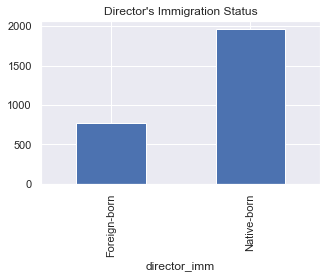

director_imm
Foreign-born     778
Native-born     1968
Name: director_imm, dtype: int64

In [419]:
a= df["director_imm"].groupby(df["director_imm"]).count()
a.plot(kind='bar')
pplt.title("Director's Immigration Status")
pplt.show()
a

Director's Gender

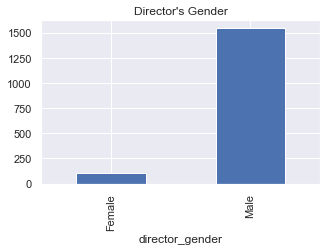

director_gender
Female     101
Male      1544
Name: director_gender, dtype: int64

In [420]:
a= df["director_gender"].groupby(df["director_gender"]).count()
a.plot(kind='bar')
pplt.title("Director's Gender")
pplt.show()
a

Year

In [ ]:
a= df["us.year"].groupby(df["us.year"]).count()
a.plot(kind='bar')
pplt.title("Year")
pplt.show()
a

Genre

In [ ]:
a= df["Genre"].groupby(df["Genre"]).count()
a.plot(kind='bar')
pplt.title("Genre")
pplt.show()
a

Distributor

In [421]:
df["Distributor"].groupby(df["Distributor"]).count()

Distributor
20th Century Fox             258
518 Media                      1
ATO Pictures                   1
Academy Pictures               1
After Dark Films               4
                            ... 
World Artists Inc.             1
Yari Film Group                3
Yari Film Group Releasing      4
Zecca Corporation              1
int´l Home Cinema              1
Name: Distributor, Length: 303, dtype: int64

Top Star(Whether the movie is acted by topstars)

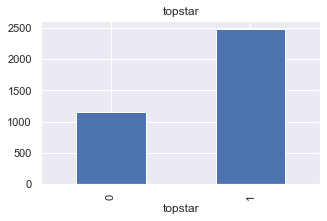

topstar
0    1148
1    2484
Name: topstar, dtype: int64

In [422]:
a= df["topstar"].groupby(df["topstar"]).count()
a.plot(kind='bar')
pplt.title("topstar")
pplt.show()
a

In [43]:
%%R


# -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

NULL


# Regression analysis


In [439]:
%%R
# load the data in R
df = read.csv(file = 'final merged data.csv');
head(df)[1:3, ];

            Name       Dirct1         Prodc1          Distributor
1   Back to Back John Kincade    Brad Krevoy Concorde Productions
2 Crash and Burn Charles Band David DeCoteau                     
3     Love Hurts   Bud Yorkin     Bud Yorkin                     
  Cinematographer1       Actor1        Actor2           Actor3       Actor4
1   James L Carter  Bill Paxton    Todd Field Apollonia Kotero  Ben Johnson
2      Mac Ahlberg  Ralph Waite  Paul E Ganus       Megan Ward Bill Moseley
3   Adam Greenberg Jeff Daniels Cynthia Sykes      Judith Ivey John Mahoney
           Actor5  Genre us.year us.quarter domestic_bo budget_nielsen
1      Luke Askew  Drama    1990         NA          NA             NA
2      Jack McGee Sci-Fi    1990         NA          NA        2500000
3 Cloris Leachman Comedy    1990         NA          NA             NA
  budget_numbers director_imm director_continent director_country
1             NA                                                 
2             NA

### Domestic box office as dependent variable

In [472]:
%%R
fit1 = feols(log(domestic_bo + sqrt(1+domestic_bo^2)) ~
                                                      director_imm + director_gender + log(1+budget_nielsen) |
                                                      us.year + Genre + Distributor,
                                                         data = df)
summary(fit1);

# fit2 = feols(log(international_bo + sqrt(1+international_bo^2)) ~ director_imm + log(1+budget_numbers) | us.year + Genre + Distributor, movies_other)
# summary(fit2)

R[write to console]: NOTE: 517 observations removed because of NA values (LHS: 417, RHS: 398, Fixed-effects: 0).

R[write to console]: Warning:
R[write to console]:  In print.fixest(object, useS4 = FALSE):
 'useS4' is not a valid argument of function print.fixest (fyi, some of
its main arguments are 'n', 'type', 'se' and 'cluster').



OLS estimation, Dep. Var.: log(domestic_bo + sqrt(1 + domestic_bo^2))
Observations: 3,115 
Fixed-effects: us.year: 21,  Genre: 21,  Distributor: 169
Standard-errors: Clustered (us.year) 
                         Estimate Std. Error t value   Pr(>|t|)    
director_immForeign-born 0.126394   0.104148  1.2136 2.3904e-01    
director_immNative-born  0.358287   0.065917  5.4355 2.5000e-05 ***
director_genderFemale    0.406712   0.129297  3.1456 5.0900e-03 ** 
director_genderMale      0.155226   0.055277  2.8081 1.0860e-02 *  
log(1 + budget_nielsen)  0.833263   0.047886 17.4010 1.5100e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-likelihood: -5,228.29   Adj. R2: 0.5988 
                          R2-Within: 0.24804 


In [479]:
%%R
fit11st = feols(log(domestic_bo + sqrt(1+domestic_bo^2)) ~
                                                         log(1+budget_nielsen) + director_gender |
                                                         us.year + Genre + Distributor,
                                                         data = df)
summary(fit11st)

fit11 = lm(resid(fit11st) ~ director_imm, df)
summary(fit11)
colnames(df)
fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = df$cluster_tdidf_first, data = df)
fit11cl


R[write to console]: NOTE: 517 observations removed because of NA values (LHS: 417, RHS: 398, Fixed-effects: 0).




t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)              -0.176540   0.053190 -3.3191 0.0009136 ***
director_immForeign-born  0.064712   0.072579  0.8916 0.3726783    
director_immNative-born   0.284690   0.061220  4.6502 3.454e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



#### Test within clusters

In [480]:
%%R
fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = df$cluster_tdidf_second, data = df)
fit11cl


t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)              -0.176540   0.053190 -3.3191 0.0009136 ***
director_immForeign-born  0.064712   0.072579  0.8916 0.3726783    
director_immNative-born   0.284690   0.061220  4.6502 3.454e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [481]:
%%R
fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = df$cluster_tdidf_second, data = df)
fit11cl


t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)              -0.176540   0.053190 -3.3191 0.0009136 ***
director_immForeign-born  0.064712   0.072579  0.8916 0.3726783    
director_immNative-born   0.284690   0.061220  4.6502 3.454e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [482]:
%%R
fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = df$cluster_lda_major_first, data = df)
fit11cl


t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)              -0.176540   0.057586 -3.0657   0.00219 ** 
director_immForeign-born  0.064712   0.066556  0.9723   0.33098    
director_immNative-born   0.284690   0.055574  5.1227 3.195e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [483]:
%%R
fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = df$cluster_lda_major_second, data = df)
fit11cl



t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)              -0.176540   0.089909 -1.9636   0.04967 *  
director_immForeign-born  0.064712   0.064868  0.9976   0.31856    
director_immNative-born   0.284690   0.069355  4.1048 4.151e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



### International box office as dependent variable

In [484]:
%%R
fit2 = feols(log(international_bo + sqrt(1+international_bo^2)) ~
                                                      director_imm + director_gender + log(1+budget_numbers) |
                                                      us.year + Genre + Distributor,
                                                      data = df)
summary(fit2);

R[write to console]: NOTE: 2,223 observations removed because of NA values (LHS: 2,025, RHS: 1,992, Fixed-effects: 0).

R[write to console]: Warning:
R[write to console]:  In print.fixest(object, useS4 = FALSE):
 'useS4' is not a valid argument of function print.fixest (fyi, some of
its main arguments are 'n', 'type', 'se' and 'cluster').



OLS estimation, Dep. Var.: log(international_bo + sqrt(1 + international_bo^2))
Observations: 1,409 
Fixed-effects: us.year: 21,  Genre: 21,  Distributor: 55
Standard-errors: Clustered (us.year) 
                         Estimate Std. Error t value   Pr(>|t|)    
director_immForeign-born 0.803828   0.182232  4.4110 2.6900e-04 ***
director_immNative-born  0.572166   0.160783  3.5586 1.9690e-03 ** 
director_genderFemale    0.608938   0.289916  2.1004 4.8579e-02 *  
director_genderMale      0.360737   0.114756  3.1435 5.1140e-03 ** 
log(1 + budget_numbers)  1.077700   0.082298 13.0950 2.8600e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-likelihood: -2,647.47   Adj. R2: 0.45075 
                          R2-Within: 0.25894 


#### Test within clusters

In [491]:
%%R
fit21st = feols(log(international_bo + sqrt(1+international_bo^2)) ~ director_gender + log(1+budget_numbers)|
                                                                   us.year + Genre + Distributor, df)
summary(fit21st)
fit22 = lm(resid(fit21st) ~ director_imm, df)
fit22cl = coeftest(fit22, vcov. = vcovCL, cluster = df$cluster_tfidf_first)
fit22cl

R[write to console]: NOTE: 2,223 observations removed because of NA values (LHS: 2,025, RHS: 1,992, Fixed-effects: 0).




t test of coefficients:

                         Estimate Std. Error t value  Pr(>|t|)    
(Intercept)              -0.43782    0.16772 -2.6105 0.0091384 ** 
director_immForeign-born  0.62112    0.18112  3.4293 0.0006225 ***
director_immNative-born   0.43820    0.14393  3.0445 0.0023741 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [492]:
%%R
fit22cl = coeftest(fit22, vcov. = vcovCL, cluster = df$cluster_tfidf_second)
fit22cl


t test of coefficients:

                         Estimate Std. Error t value  Pr(>|t|)    
(Intercept)              -0.43782    0.15572 -2.8117 0.0049969 ** 
director_immForeign-born  0.62112    0.16476  3.7699 0.0001701 ***
director_immNative-born   0.43820    0.11522  3.8031 0.0001490 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [493]:
%%R
fit22cl = coeftest(fit22, vcov. = vcovCL, cluster = df$cluster_lda_major_first)
fit22cl


t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)              -0.437824   0.117686 -3.7203 0.0002069 ***
director_immForeign-born  0.621122   0.083518  7.4370 1.784e-13 ***
director_immNative-born   0.438203   0.094589  4.6327 3.943e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [494]:
%%R
fit22cl = coeftest(fit22, vcov. = vcovCL, cluster = df$cluster_lda_major_second)
fit22cl



t test of coefficients:

                          Estimate Std. Error t value  Pr(>|t|)    
(Intercept)              -0.437824   0.111749 -3.9179 9.361e-05 ***
director_immForeign-born  0.621122   0.081309  7.6390 4.026e-14 ***
director_immNative-born   0.438203   0.126083  3.4755 0.0005254 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2
3. NLTK: @book{bird2009natural,
  title={Natural language processing with Python: analyzing text with the natural language toolkit},
  author={Bird, Steven and Klein, Ewan and Loper, Edward},
  year={2009},
  publisher={" O'Reilly Media, Inc."}
}


# Appendix

example showing how the preprocessing works

In [30]:
doc_sample = movies_df_sub[movies_df_sub['Title'] == 'Madagascar'].values[0][7]
print(doc_sample)
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


At the Central Park Zoo, Marty the zebra is celebrating his tenth birthday, but has grown bored with his daily routine and longs to experience the wild. Marty's best friend is Alex the lion, who enjoys showing off for the public and his celebrity status as "the King of New York City". Alex attempts to cheer Marty up, but Marty, still unsatisfied, gets some tips from the zoo's penguins—Skipper, Kowalski, Rico, and Private—who are trying to escape the zoo, and follows them out. Alex, Melman the giraffe, and Gloria the hippopotamus pursue Marty in an attempt to convince him to return. The four, along with the penguins and two chimpanzees named Mason and Phil, find themselves at Grand Central Station, where they are quickly sedated via tranquillizer gun when Alex's attempt to communicate with humans is mistaken for aggression. The zoo, under pressure from anti-captivity activists, is forced to ship the escaped animals by sea to a Kenyan wildlife preserve. During their travels, the penguins

testing with name replacement

In [ ]:
miniplot = movies_df_sub.Plot[5]
# miniplot.head()

In [ ]:
# print(miniplot)
# tags = ['Alice', 'John']
for tag in names:
    miniplot = miniplot.replace(tag, 'Character')

print(miniplot)

In [ ]:
for tag in name:
    miniplot = re.sub(r'\b' + tag + r'\b', 'Character', miniplot)
print(miniplot)

In [ ]:
Plot = movies_df_sub.Plot.sample(10)
for i in Plot.index:
    for tag in name:
        Plot[i] = re.sub(r'\b' + tag + r'\b', 'Character', Plot[i])
print(Plot)
# Plot.to_csv('test.csv', index=False)


In [ ]:
# %%time
# name = allnames.name.to_list()
# for tag in name[:100]:
#     # print(tag)
#     nameexp = re.compile(r'\b'+tag+r'\b')
#     for i in movies_df_sub.index[:100]:
#         movies_df_sub.Plot[i] = nameexp.sub('Character', movies_df_sub.Plot[i])

In [ ]:
# %%time
# from multiprocessing import Pool
#
# name = allnames.name.to_list()
#
# def f(x):
#     for tag in name[:5]:
#         re.sub(r'\b' + tag + r'\b', 'Character', x)
#
# if __name__ == '__main__':
#     with Pool(4) as p:
#         p.map(f, movies_df_sub.Plot[:5])

In [ ]:
'Grace' in name

In [499]:
!jupyter nbconvert --to html groupproject.ipynb
# os.system('jupyter nbconvert --to html groupproject.ipynb')


[NbConvertApp] Converting notebook groupproject.ipynb to html
[NbConvertApp] Writing 1011770 bytes to groupproject.html
